In [1]:
import numpy as np
import pandas as pd

# вывожу путь к файлам директории
import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/test.csv
data/train.csv
data/sample_submission.csv


### Идеи по улучшению модели
- добавить субъективный признак успешности (число от 0 до 1) (есть мащина +0.3, нет дома (-0.3) и тд)
- соотношение количества запросов на кооичество отказных заявок
- работа с данными
- признак как менялся курс валюты за год, помесяцам (тк данные только за 2014)
- кто живет и работает по одному адресу более илименее склонны к дефолту? (Возможно, лучше выделить отдельно призак живущих и работающим по одному адрес - 1, по разным адресам - 0)
- dummy по месяцам
- Среднее количество обращений в БКИ по доходу - значений признака слишком много, возможно, стоит разделитьпо квантилям
- запустить валидацию xgb дополнительно по параметрам learning_rate=0.02, n_estimators=600

In [2]:
import datetime
# быстрый разведочный анализ
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV


from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from math import log as log

# Данные

In [3]:
# путь к файлам
path = 'data'

In [4]:
train = pd.read_csv(path +'/train.csv')
test = pd.read_csv(path +'/test.csv')
sample = pd.read_csv(path +'/sample_submission.csv')

In [5]:
# рассмотрим тренировочные данные
print(train.info())
print('Train size: ', train.shape)
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [6]:
print(test.info())
print('Test size: ', train.shape)
test.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [7]:
print(sample.info())
print(sample.shape)
sample.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB
None
(24354, 2)


,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


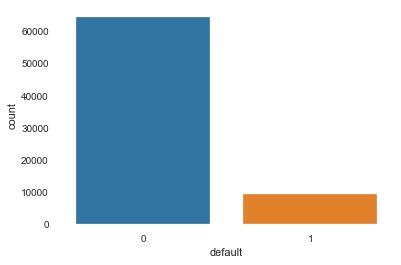

In [8]:
# рассмотрим распределение целевого признака
plot = sns.countplot(train['default'])

Hmm.. there are way more clients who go into default

In [9]:
# объединим тренировочную и тестовую выборки для препроцессинга
train['sample'] = 1   # train
test['sample'] = 0    # test
test['default'] = -1  # временное значение
data = train.append(test, sort=False).reset_index(drop=True)

In [10]:
# объединенный датафрейм
print(data.info())
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

(110148, 20)

<h2>Описания полей</h2>
<ul>
<li><p><code>client_id</code> - идентификатор клиента</p></li>
<li><p><code>education</code> - уровень образования</p></li>
<li><p><code>sex</code> - пол заемщика</p></li>
<li><p><code>age</code> - возраст заемщика</p></li>
<li><p><code>car</code> - флаг наличия автомобиля</p></li>
<li><p><code>car_type</code> - флаг автомобиля иномарки</p></li>
<li><p><code>decline_app_cnt</code> - количество отказанных прошлых заявок</p></li>
<li><p><code>good_work</code> - флаг наличия “хорошей” работы</p></li>
<li><p><code>bki_request_cnt</code> - количество запросов в БКИ</p></li>
<li><p><code>home_address</code> - категоризатор домашнего адреса</p></li>
<li><p><code>work_address</code> -  категоризатор рабочего адреса</p></li>
<li><p><code>income</code> - доход заемщика</p></li>
<li><p><code>foreign_passport</code> - наличие загранпаспорта</p></li>
<li><p><code>sna</code> - связь заемщика с клиентами банка</p></li>
<li><p><code>first_time</code> - давность наличия информации о заемщике</p></li>
<li><p><code>score_bki</code> - скоринговый балл по данным из БКИ</p></li>
<li><p><code>region_rating</code> - рейтинг региона</p></li>
<li><p><code>app_date</code> - дата подачи заявки</p></li>
<li><p><code>default</code> - флаг дефолта по кредиту </p></li>
</ul></div>

# Разведочный анализ (EDA)

In [11]:
# разделяю по типам признаков для предобработки
num_cols = ['age','decline_app_cnt','score_bki','income','bki_request_cnt','region_rating'] 
cat_cols = ['education','work_address','home_address','sna','first_time'] 
bin_cols = ['sex','car','car_type','good_work','foreign_passport'] 

# *Числовые признаки*

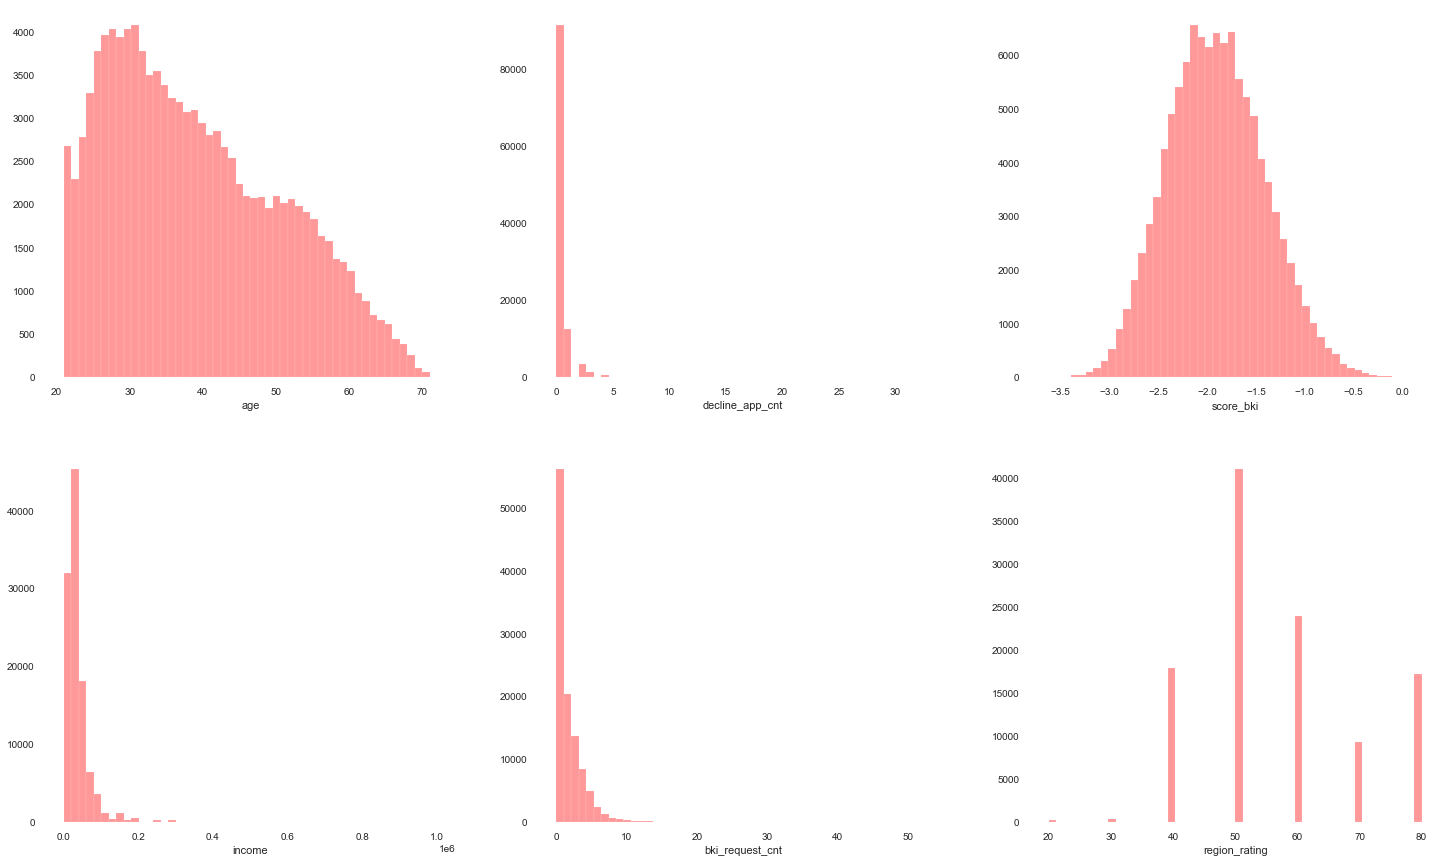

In [12]:
# рассмотрим числовые значения
fig, axes = plt.subplots(2, 3, figsize=(25,15))

for i,col in enumerate(num_cols):
    sns.distplot(data[col], kde=False, ax=axes.flat[i], color="r")

### Некоторые признаки смещены влево

### Логорифмируем смещенные признаки для нормального распределения

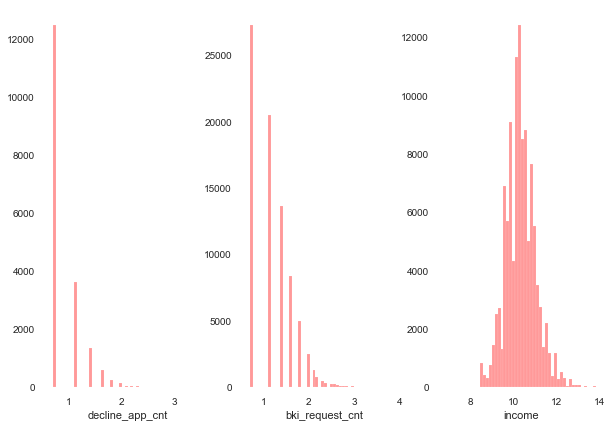

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(10,7))
for i,col in enumerate(['decline_app_cnt', 'bki_request_cnt', 'income']):
    data[col] = np.log(data[col] + 1)
    sns.distplot(data[col][data[col] > 0].dropna(), ax=axes.flat[i],kde = False, rug=False,color="r")    

### Распределение нормальное

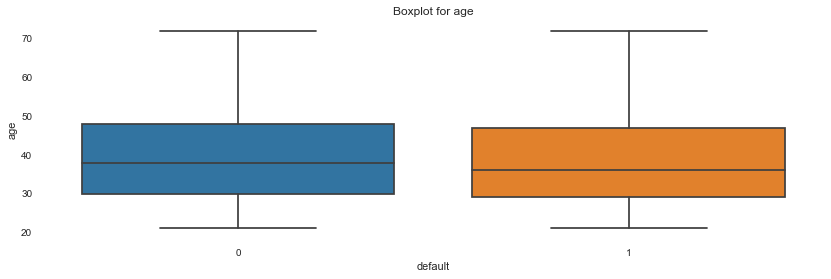

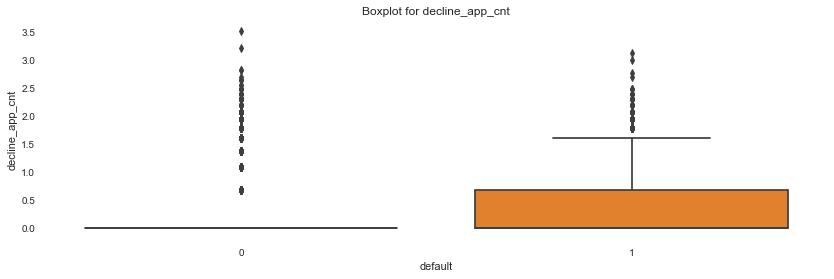

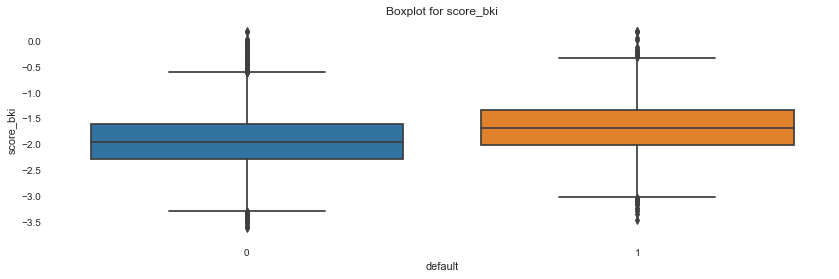

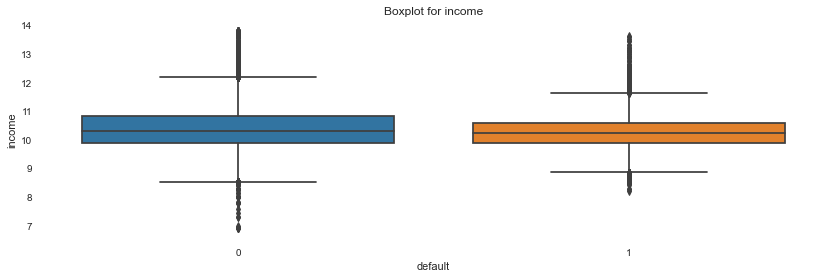

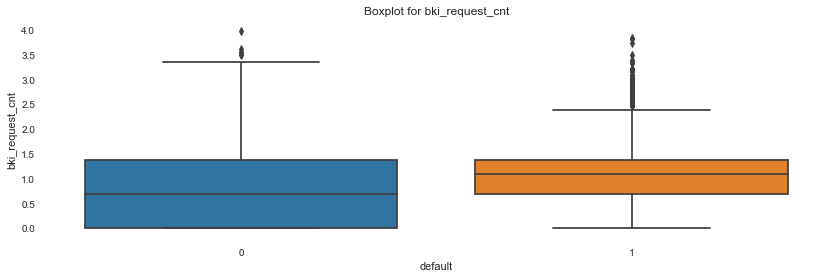

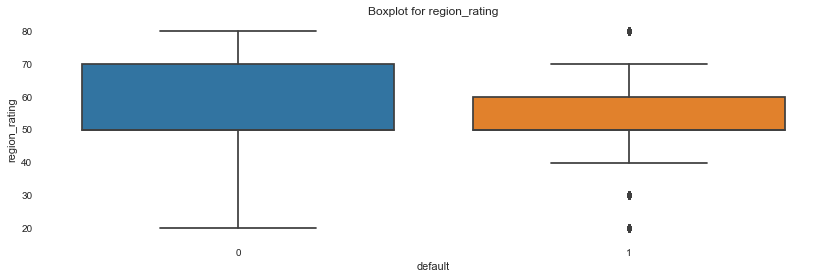

In [14]:
# Построим боксплоты для числовых признаков
def boxplot(col):
    fig, axes = plt.subplots(figsize = (14, 4))
    sns.boxplot(x='default', y=col, data=data[data['sample']==1],ax=axes)
    axes.set_title('Boxplot for ' + col)
    plt.show()
for col in num_cols:
    boxplot(col)

## Выводы по числовым признакам:

* Дефолт совершают, как правило, более молодые

* Дефолт совершают люди, которые имеют более высокий скоринговый рейтинг - почему?

* Платежеспособные люди живут, как правило, в регионах с более высоким рейтингом

* Количество запросов в БКИ, обычно, выше у совершающих дефолт

* Платежеспособные люди имеют более высокий доход

# *Категориальные признаки*

## Рассмотри признак "Образование"

Missing education values:
 478


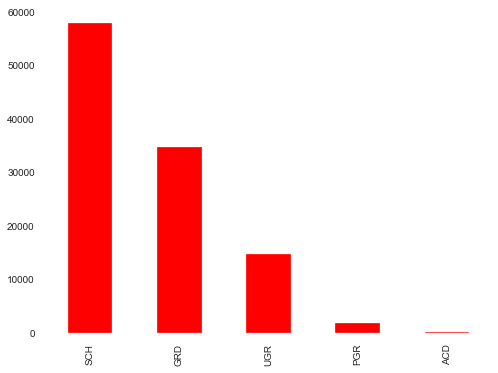

In [15]:
data.education.value_counts().plot(kind="bar",figsize=(8,6),color="r")
print("Missing education values:\n",data.education.isna().sum())

In [16]:
data.education = data.education.fillna("SCH") # заменим пустые значения на самое популярное

Смотрим зависимость дохода от уровня образования

<AxesSubplot:xlabel='education', ylabel='income'>

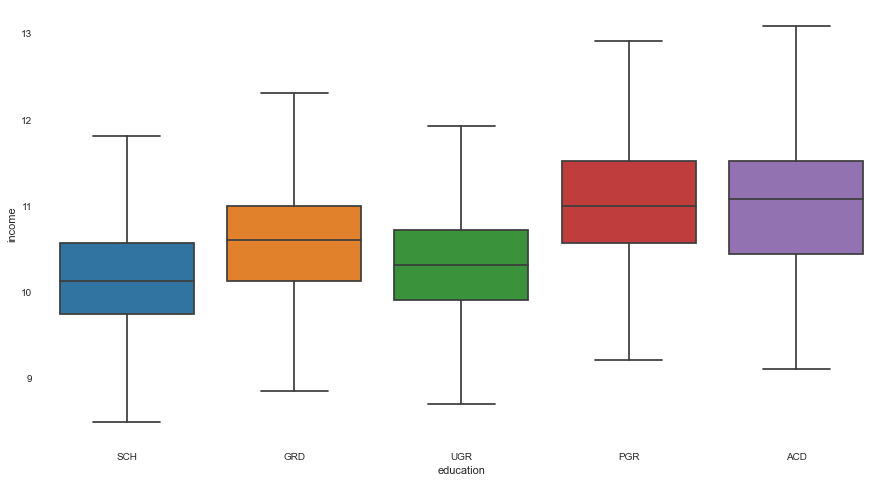

In [17]:
plt.figure(figsize=(15, 8))
sns.boxplot(x="education", y="income", data=data, showfliers=False)

Люди с более высоким образованием имеют, как правило, более высокий доход

## Построим корреляционную матрицу

<AxesSubplot:>

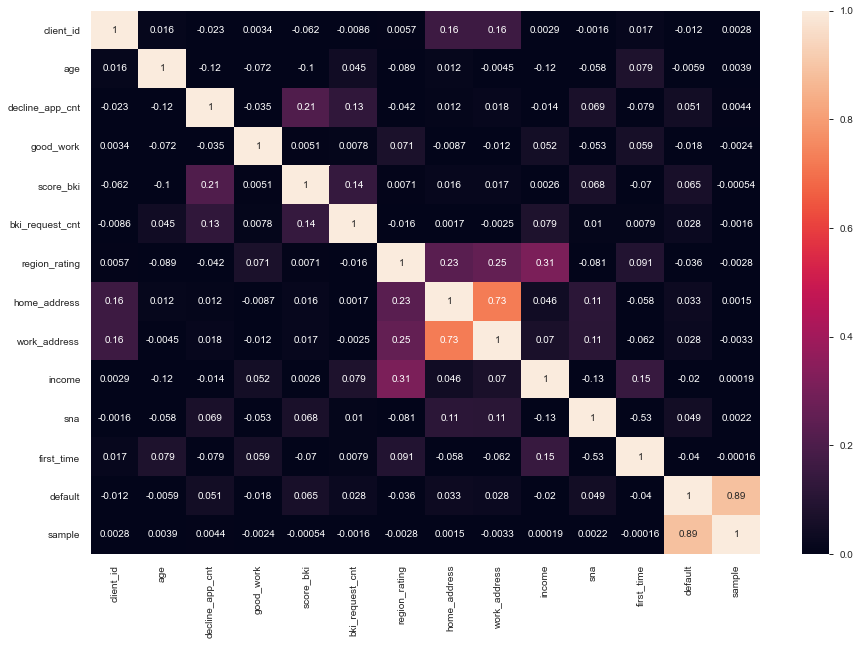

In [18]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.corr(), vmin=0, vmax=1, annot = True)

- Признаки "домашний" и "рабочий" адресы имеют высокую зависимость
- Нет признаков, сильно зависимых с целевым

# *Feature engineering*

**Новый признак: сколько дней прошло с 1-го запроса**

In [19]:
data['app_date'] = pd.to_datetime(data.app_date)
data['app_date'] = data['app_date'].apply(lambda x: (x - data['app_date'].min()).days)

In [20]:
# копируем датафрейм
df = data.copy()

**Новый признак: Дом далеко от работы**

Предположим, если адрес работы и адрес дома не равны по числовому значению признака - значит человеку приходится долго добираться до работы

In [21]:
df['home_work'] = 0
for i in range(len(df)):
    if df['home_address'][i] == df['work_address'][i]:
        df['home_work'][i] = 0
    else:
        df['home_work'][i] = 1

/Users/rus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/rus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


**Новый признак: Количество отказных заявок/Количество запросов**

In [22]:
df['bki/decline'] = 0
for i in range(len(df)):
    if df['bki_request_cnt'][i] != 0 and df['decline_app_cnt'][i] != 0:
        df['bki/decline'][i] = df['decline_app_cnt'][i]/df['bki_request_cnt'][i]
    else:
        df['bki/decline'][i] = 0

/Users/rus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/rus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


**Новый признак: Средний доход по возрасту**

In [23]:
mean_income = df.groupby('age')['income'].mean().to_dict()
df['mean_income_age'] = df['age'].map(mean_income)

**Новый признак: Максимальный доход по возрасту**

In [24]:
max_income = df.groupby('age')['income'].max().to_dict()
df['max_income_age'] = df['age'].map(max_income)

**Новый признак: Нормализованный доход по возрасту**

In [25]:
# только положительные значения
df["normalized_income"] = abs((df.income - df.mean_income_age)/df.max_income_age)

**Новый признак: среднее количество обращений в БКИ по возрасту**

In [26]:
mean_bki = df.groupby('age')['bki_request_cnt'].mean().to_dict()
df['mean_requests_age'] = df['age'].map(mean_bki)

**Новый признак: Среднее количество обращений в БКИ по доходу**

In [27]:
mean_bki_inc = df.groupby('income')['bki_request_cnt'].mean().to_dict()
df['mean_requests_income'] = df['income'].map(mean_bki_inc)

**Новый признак: Средний доход по региону**

In [28]:
mean_income_rat = df.groupby('region_rating')['income'].mean().to_dict()
df['mean_income_region'] = df['region_rating'].map(mean_income_rat)

## Кодирование бинарных и категориальных признаков признаков

In [29]:
# перекодируем текстовые значения в бинарных признаках на числовые
mapp = {}
label_encoder = LabelEncoder()
for col in bin_cols:
    # перекодировка
    df[col] = label_encoder.fit_transform(df[col])
    # сохраняем значения перекодировки в словаре
    mapp[col] = dict(enumerate(label_encoder.classes_))

In [30]:
# перекодируем текстовые значения в категориальных признаках на числовые
mappc = {}
enc = OneHotEncoder()
for col in cat_cols:
    # перекодировка
    df[col] = label_encoder.fit_transform(df[col])
    # сохраняем значения перекодировки в словаре
    mappc[col] = dict(enumerate(label_encoder.classes_))

In [31]:
# Словарь категориальных и бинарных признаков
print(mapp)
print(mappc)

{'sex': {0: 'F', 1: 'M'}, 'car': {0: 'N', 1: 'Y'}, 'car_type': {0: 'N', 1: 'Y'}, 'good_work': {0: 0, 1: 1}, 'foreign_passport': {0: 'N', 1: 'Y'}}
{'education': {0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}, 'work_address': {0: 1, 1: 2, 2: 3}, 'home_address': {0: 1, 1: 2, 2: 3}, 'sna': {0: 1, 1: 2, 2: 3, 3: 4}, 'first_time': {0: 1, 1: 2, 2: 3, 3: 4}}


In [32]:
df.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default', 'sample', 'home_work',
       'bki/decline', 'mean_income_age', 'max_income_age', 'normalized_income',
       'mean_requests_age', 'mean_requests_income', 'mean_income_region'],
      dtype='object')

In [33]:
# обновляем списки признаков по типу
num_cols = ['age','decline_app_cnt','score_bki','income','bki_request_cnt','app_date', 'mean_income_age','region_rating','max_income_age', 'normalized_income',
       'mean_requests_age', 'mean_requests_income', 'mean_income_region', 'bki/decline'] # numerical
cat_cols = ['education','work_address','home_address','sna','first_time'] # categorical
bin_cols = ['sex','car','car_type','good_work','foreign_passport','home_work'] # binary

## Обработка выбросов

In [34]:
for col in num_cols:
    median = df[col].median()
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    print("Columns: ", col)
    print('25%: {},'.format(perc25), '75%: {},'.format(perc75), 
          "IQR: {}, ".format(IQR),"Borderline: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

Columns:  age
25%: 30.0, 75%: 48.0, IQR: 18.0,  Borderline: [3.0, 75.0].
Columns:  decline_app_cnt
25%: 0.0, 75%: 0.0, IQR: 0.0,  Borderline: [0.0, 0.0].
Columns:  score_bki
25%: -2.2604336700000003, 75%: -1.5678881525, IQR: 0.6925455175000004,  Borderline: [-3.299251946250001, -0.5290698762499992].
Columns:  income
25%: 9.90353755128617, 75%: 10.778977123006351, IQR: 0.8754395717201806,  Borderline: [8.590378193705899, 12.092136480586621].
Columns:  bki_request_cnt
25%: 0.0, 75%: 1.3862943611198906, IQR: 1.3862943611198906,  Borderline: [-2.0794415416798357, 3.465735902799726].
Columns:  app_date
25%: 33.0, 75%: 89.0, IQR: 56.0,  Borderline: [-51.0, 173.0].
Columns:  mean_income_age
25%: 10.305358726970132, 75%: 10.444420558250247, IQR: 0.13906183128011484,  Borderline: [10.096765980049959, 10.653013305170418].
Columns:  region_rating
25%: 50.0, 75%: 60.0, IQR: 10.0,  Borderline: [35.0, 75.0].
Columns:  max_income_age
25%: 13.353476685668044, 75%: 13.81451105863119, IQR: 0.46103437296

Выбросы отсутствуют

## Стандартизация

In [35]:
df1 = df.copy()
dataset = df.copy()

In [36]:
dataset[num_cols] = pd.DataFrame(StandardScaler().fit_transform(df[num_cols]), columns = df[num_cols].columns)

## F-test

оцениваю степень линейной зависимости между регрессорами и целевым признаком

### ***Числовые признаки***

In [37]:
# тренировочная выборка
data_temp = dataset.loc[data['sample'] == 1] 

<AxesSubplot:>

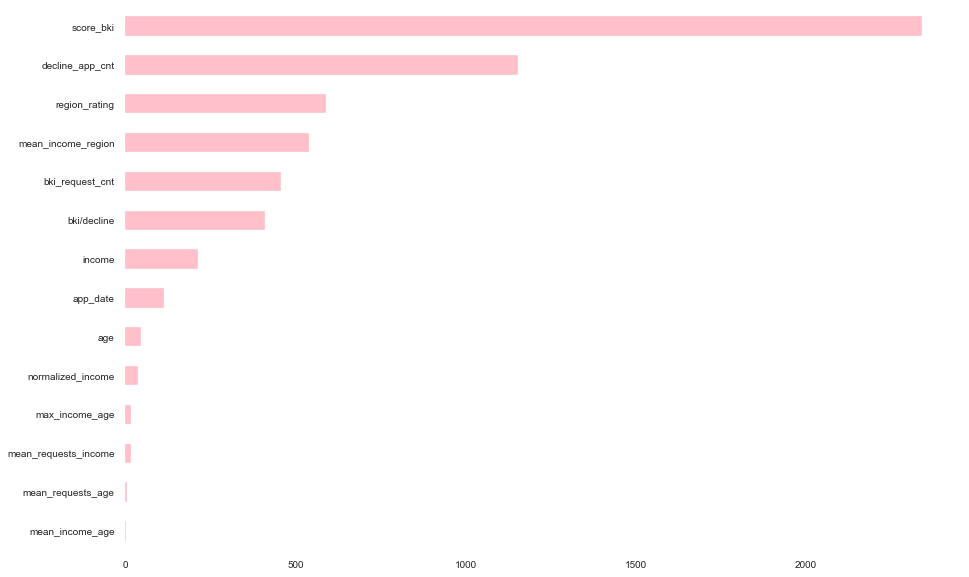

In [38]:
imp_num = pd.Series(f_classif(data_temp[num_cols], data_temp['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', color='pink')

### ***Категориальные и бинарные признаки***

In [39]:
data_temp.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default', 'sample', 'home_work',
       'bki/decline', 'mean_income_age', 'max_income_age', 'normalized_income',
       'mean_requests_age', 'mean_requests_income', 'mean_income_region'],
      dtype='object')

<AxesSubplot:>

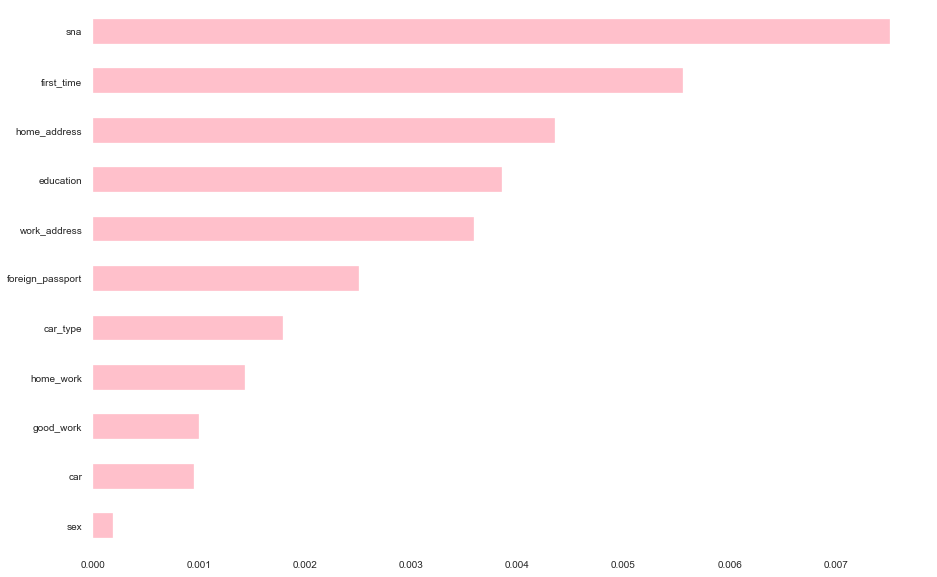

In [40]:
imp_cat = pd.Series(mutual_info_classif(data_temp[bin_cols + cat_cols], data_temp['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', color='pink')

## Собираю готовый dataframe

In [41]:
df = pd.get_dummies(dataset, prefix=cat_cols, columns=cat_cols) # dummy-переменные

# Обучим модель

In [42]:
# разделяю на тренировочную и тестовую выборки
train_df = df.query('sample == 1').drop(['sample','client_id'], axis=1)
test_df = df.query('sample == 0').drop(['sample','client_id'], axis=1)

In [43]:
train_df.columns

Index(['app_date', 'sex', 'age', 'car', 'car_type', 'decline_app_cnt',
       'good_work', 'score_bki', 'bki_request_cnt', 'region_rating', 'income',
       'foreign_passport', 'default', 'home_work', 'bki/decline',
       'mean_income_age', 'max_income_age', 'normalized_income',
       'mean_requests_age', 'mean_requests_income', 'mean_income_region',
       'education_0', 'education_1', 'education_2', 'education_3',
       'education_4', 'work_address_0', 'work_address_1', 'work_address_2',
       'home_address_0', 'home_address_1', 'home_address_2', 'sna_0', 'sna_1',
       'sna_2', 'sna_3', 'first_time_0', 'first_time_1', 'first_time_2',
       'first_time_3'],
      dtype='object')

In [44]:
X = train_df.drop(['default'], axis=1).values
y = train_df['default'].values # целевой признак

In [45]:
# разделяю выборку на тренировочную и валидационную
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=69)

In [46]:
lr = LogisticRegression(max_iter = 1000)

In [47]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_valid)

## **ROC AUC**

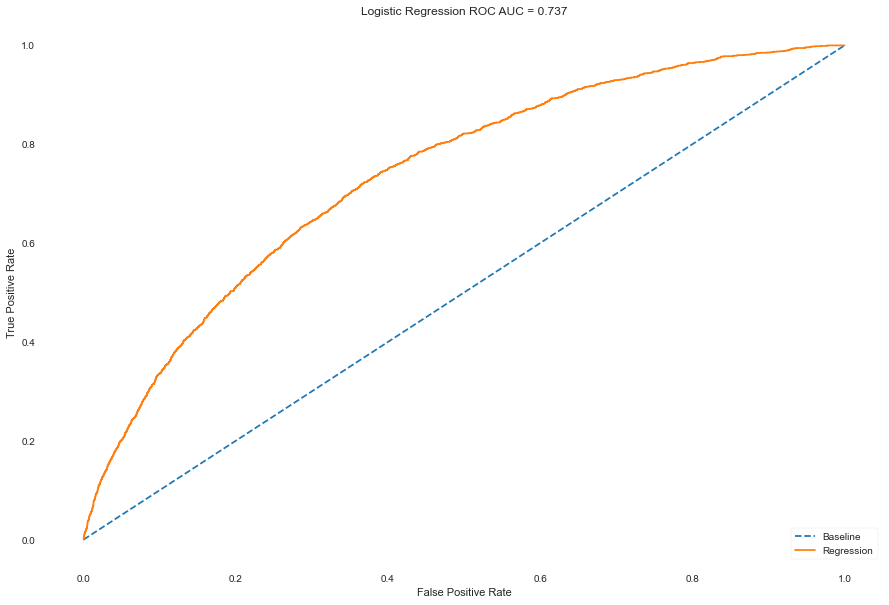

In [48]:
probs = lr.predict_proba(X_valid)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_valid, probs)
roc_auc = roc_auc_score(y_valid, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [49]:
print('accuracy_score:',accuracy_score(y_valid,y_pred))
print('precision_score:',precision_score(y_valid,y_pred))
print('recall_score:',recall_score(y_valid,y_pred))
print('f1_score:',f1_score(y_valid,y_pred))

accuracy_score: 0.8723577235772357
precision_score: 0.4838709677419355
recall_score: 0.031914893617021274
f1_score: 0.059880239520958084


Модель имеет низкие показатели

### Confusion matrix

[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

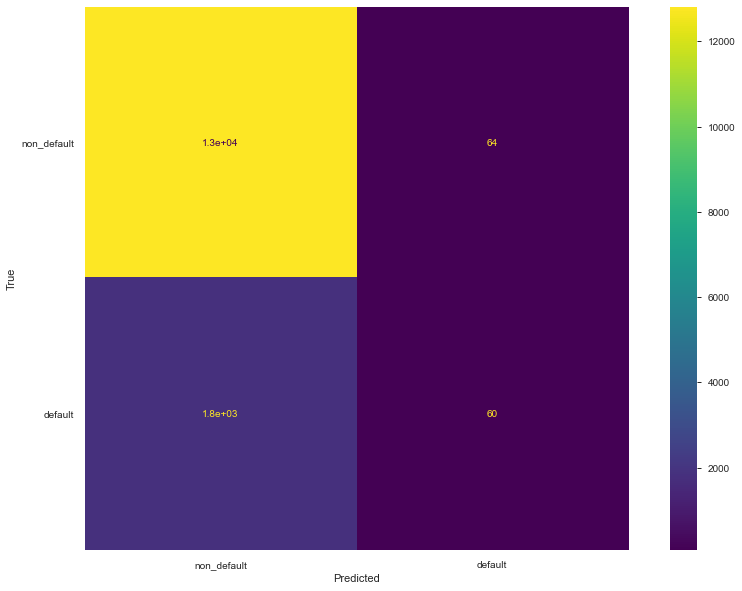

In [50]:
cm = confusion_matrix(y_valid, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['non_default','default'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')

Модель предсказывает, что практически все не дефолтные

# XGB классификатор

In [51]:
# параметры для перебора
params = {
        'learning_rate' : [0.05, 0.1, 0.2,],
        'n_estimators' : [150, 200, 250],
        'min_child_weight': [4, 5, 6],
        'gamma': [0.3, 0.5, 0.8],
        'subsample': [0.9, 1.0, 1.2],
        'colsample_bytree': [0.5, 0.6, 0.7],
        'max_depth': [4, 5, 6]
        }

Золотой стандарт для задач <a href="https://habr.com/ru/post/270367/">классификации</a>

In [52]:
from xgboost import XGBClassifier
# кросс-валидатор
from sklearn.model_selection import StratifiedKFold

### Разделяю даннные на тренировочные и тестовые

In [53]:
data = df.copy()

In [54]:
train_data = data.query('sample == 1').drop(['sample','client_id'], axis=1)
test_data = data.query('sample == 0').drop(['sample','client_id'], axis=1)

X_train = train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)

### XGBClassifier

In [55]:
xgb = XGBClassifier(objective='binary:logistic', silent=True, nthread=1)

In [56]:
# разбиение выборки для проверки
folds = 3
param_comb = 7

# перекрестная валидация
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

# рандомизированный поиск по гиперпараметрам
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

# обучаю модель по лучшим подобранным гиперпараметрам
random_search.fit(X_train, y_train)


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  21 out of  21 | elapsed:  1.2min finished
/Users/rus/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:18:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:18:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f8600435a50>,
                   error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_wei...
                   iid='deprecated', n_iter=7, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7],
                                        'gamma': [0.3, 0.5, 0.8],
                                        'learn

**Коэффициент Джини больше подходит для оценки модели в условиях сильной несбалансированности**

In [57]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best roc_auc score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([19.60157641, 14.97286669,  0.06011526, 19.53971942,  0.0549043 ,
       21.14431667,  9.08224026]), 'std_fit_time': array([0.11382178, 0.37578098, 0.00092278, 0.10784154, 0.00057825,
       0.1018883 , 0.40380116]), 'mean_score_time': array([0.1729633 , 0.12715801, 0.        , 0.13113864, 0.        ,
       0.16472475, 0.08708143]), 'std_score_time': array([0.00919851, 0.00100122, 0.        , 0.00148942, 0.        ,
       0.00176434, 0.00569097]), 'param_subsample': masked_array(data=[1.0, 1.0, 1.2, 1.0, 1.2, 1.0, 0.9],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[250, 250, 150, 250, 250, 250, 150],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[6, 5, 5, 6, 6, 6, 5],
             mask=[False, False, False, False, Fals

### Предсказываем целевой признак для тестовой выборки

In [58]:
test_data = X_test
y_pred = random_search.predict_proba(test_data)
results_df = pd.DataFrame(data={'client_id':test['client_id'], 'default':y_pred[:,1]})

In [59]:
results_df

,client_id,default
0,74835,0.035214
1,17527,0.244092
2,75683,0.067277
3,26883,0.063449
4,28862,0.016360
...,...,...
36344,83775,0.371529
36345,106254,0.023375
36346,81852,0.321019
36347,1971,0.299913


### Формирую csv-файл с предсказанными вероятностями

In [60]:
results_df.to_csv('submission2.csv', index=False)